In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config Completer.use_jedi = False
%matplotlib inline

## Import spettri puri e spettri di sampling

In [2]:
#definisco i nomi delle colonne
names = ['wn']+[f'r{k}c{i}' for k in range(1,12) for i in range(1,12)] #wn -> wave number  r -> row c -> column

### Importo solo il primo dei due campioni

In [3]:
#quì importiamo i dati dei sampling in dataframes pandas, la colonna dei numeri d'onda è una unica per tutti
data = pd.read_csv('../data/raw/S1_mapA_11x11.txt', delim_whitespace=True, names=names)
data_bkg = pd.read_csv('../data/raw/S1_bkg_mapA_11x11.txt', delim_whitespace=True, names=names)

In [4]:
# gli spettri Raman dei materiali puri hanno ognuno uno wn diverso, generiamo dunque un dataframe vuoto delle
# dimensioni corrette, e poi aggiungiamo 2 colonne per spettro con wn e l'intensità (probabilmente c'è un 
# metodo migliore)

# definisco i nomi dei vari materiali usando il file che li contiene tutti
pure_material_names=[]
with open('../data/raw/Database Raman/BANK_LIST.dat') as f:
    pure_material_names=[i[1:len(i)-5] for i in f.readlines()]
l=[]
for i in range(len(pure_material_names)):
    l.append(pd.read_csv('../data/raw/Database Raman/'+pure_material_names[i]+'.txt', delim_whitespace=True, names=[pure_material_names[i]+'_wl',pure_material_names[i]+'_I']).size)
max_size=int(max(l)/2)

In [5]:
# genero un dataframe vuoto per poter usare il metodo join
pure_materials = pd.DataFrame(np.zeros(max_size),columns=['empty'])
# importiamo i dati: nome_I (intensità) e nome_wn
for i in range(len(pure_material_names)):
    pure_materials=pure_materials.join(pd.read_csv('../data/raw/Database Raman/'+pure_material_names[i]+'.txt', delim_whitespace=True, names=[pure_material_names[i]+'_wn',pure_material_names[i]+'_I']))
    
pure_materials.drop('empty', axis = 1,inplace=True)

pure_materials 
# occhio che hanno lunghezze diverse, se faccio qualcosa sui dati devo tenere conto che alcune righe sono NaN! 

,Albite_wn,Albite_I,Almandine_wn,Almandine_I,Amesite_wn,Amesite_I,Anatase_wn,Anatase_I,Andradite_wn,Andradite_I,...,Talc_wn,Talc_I,Titanite_wn,Titanite_I,Tremolite_wn,Tremolite_I,Zircon_wn,Zircon_I,Zoisite_wn,Zoisite_I
0,100.0000,0.00000,100.0000,0.000000,100.0000,0.000000,100.0000,0.00000,100.0000,0.000000,...,100.0000,0.000000,100.0000,0.0000,100.0000,0.000000,100.0000,0.000000,100.0000,0.000000
1,130.3772,0.00000,127.8412,0.000000,108.7196,0.000000,119.7566,0.00000,122.4867,0.000000,...,153.7797,0.000000,150.2341,0.0000,141.9265,0.000000,155.9293,0.000000,163.1987,0.000000
2,130.8593,29.94379,128.3233,0.388184,109.2017,6.031250,120.2387,228.53710,122.9688,8.033752,...,154.2619,0.392578,150.7162,167.7500,142.4086,4.830078,156.4115,24.014160,163.6808,18.185550
3,131.3414,40.09552,128.8054,0.040894,109.6838,1.233398,120.7209,27.95508,123.4509,7.316895,...,154.7440,9.555908,151.1983,283.5840,142.8907,0.161621,156.8936,35.441410,164.1630,26.076170
4,131.8235,32.20599,129.2875,14.570310,110.1660,6.476074,121.2030,84.98828,123.9330,2.533508,...,155.2261,41.726320,151.6805,256.0781,143.3728,6.734375,157.3757,5.512695,164.6451,3.950195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Spettri puri

Qui sotto sono riportati alcuni spettri, con il background, per far vedere come si comportano. 

In [6]:
def raman_plot():
    """
    Funzione che serve per settare la dimensione dell'immgine e i label degli assi.
    """
    plt.figure(figsize=(16,6))
    plt.xlabel("wave number [1/cm]")
    plt.ylabel("Intensity")

**Spettro pure Albite**

Spettro pure Albite


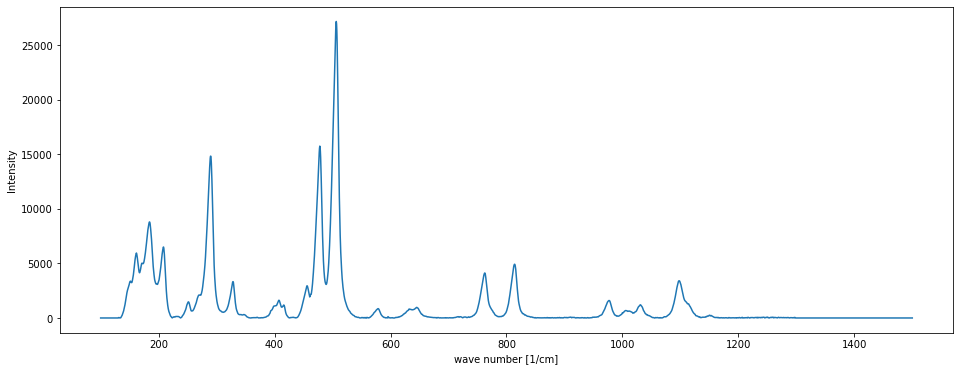

In [7]:
raman_plot()
plt.plot(pure_materials.Albite_wn,pure_materials.Albite_I)

**Tutti gli spettri puri**

Tutti gli spettri puri


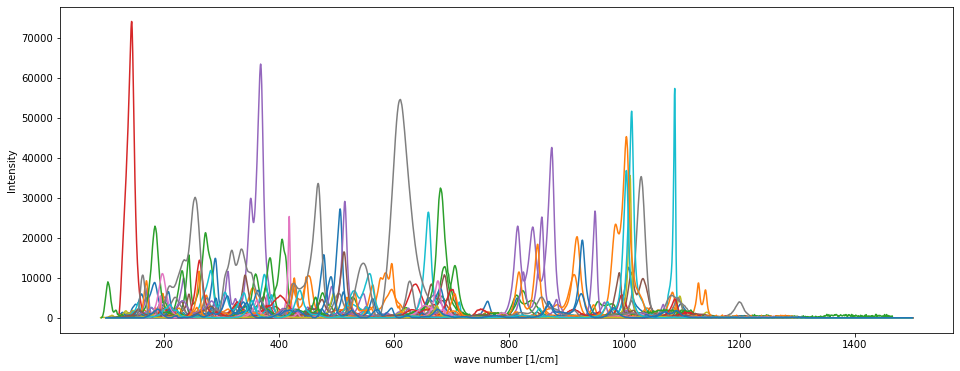

In [8]:
raman_plot()
for i in range(len(pure_material_names)):
    plt.plot(pure_materials[pure_material_names[i]+'_wn'],pure_materials[pure_material_names[i]+'_I'])

Da questi spettri, molto meno rumorosi di quelli del sample, capiamo diverse cose:
1. **Per numeri d'onda superiori a 1250 $cm^{-1}$ tutti gli spettri Raman non presentano picchi, l'intensità a piccole lunghezze d'onda è nulla!**
2. **Gli spettri Raman, relativamente alle altezze dei picchi, non presentano un offset rilevante**
3. **Le FWHM dei picchi sono, certe volte, importanti: fino a 100 $cm^{-1}$.**
4. **Lo spettro fino a circa (dopo troviamo meglio questo punto) 1250 $cm^{-1}$ è densamente popolato.**

### Normalizzazione spettri puri

In [9]:
# qui abbiamo usato dropna per risolvere il problema che alcuni spettri hanno un numero diverso di dati.
for i in pure_material_names:
    pure_materials[i+'_I']=pure_materials[i+'_I']/np.trapz(abs(pure_materials[i+'_I'].dropna()), x=pure_materials[i+'_wn'].dropna())

**Tutti gli spettri puri normalizzati**

Tutti gli spettri puri normalizzati


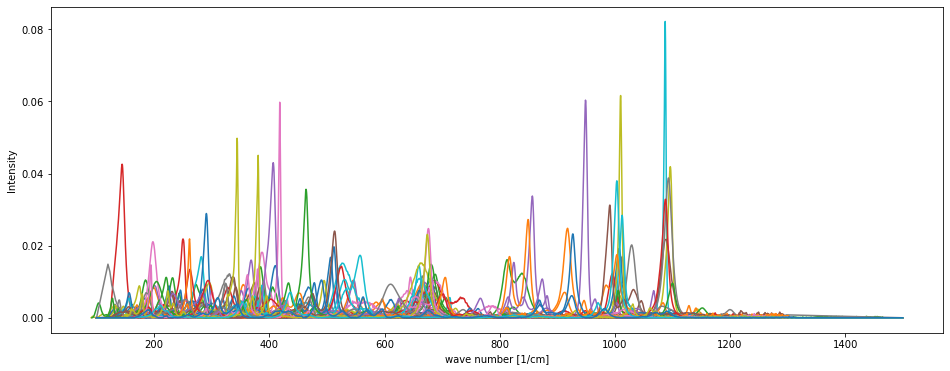

In [10]:
raman_plot()
for i in range(len(pure_material_names)):
    plt.plot(pure_materials[pure_material_names[i]+'_wn'],pure_materials[pure_material_names[i]+'_I'])

Da questi spettri, molto meno rumorosi di quelli del sample, capiamo diverse cose:
1. **Per numeri d'onda superiori a 1250 $cm^{-1}$ tutti gli spettri Raman non presentano picchi, l'intensità a piccole lunghezze d'onda è nulla!**
2. **Gli spettri Raman, relativamente alle altezze dei picchi, non presentano un offset rilevante**
3. **Le FWHM dei picchi sono, certe volte, importanti: fino a 100 $cm^{-1}$.**
4. **Lo spettro fino a circa (dopo troviamo meglio questo punto) 1250 $cm^{-1}$ è densamente popolato.**

## Spettri sperimentali

### Con cosa stiamo lavorando

**Spettri sperimentali non normalizzati con rumore di background**

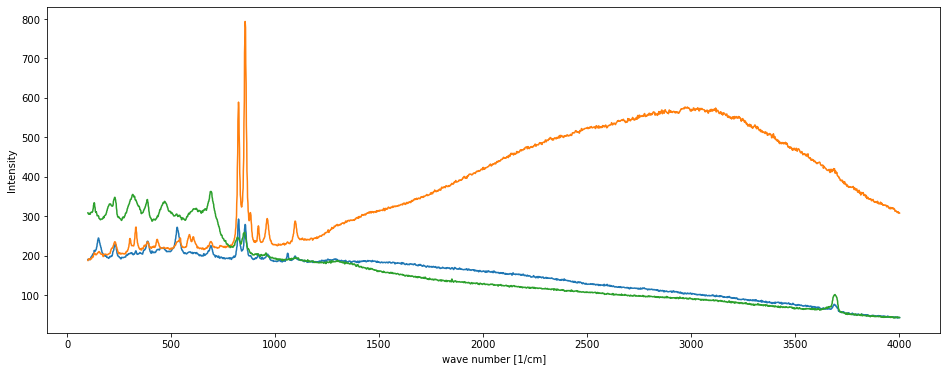

In [11]:
raman_plot()
plt.plot(data.wn,data.r1c1)
plt.plot(data.wn,data.r1c2)
plt.plot(data.wn,data.r1c3);

**Tutti gli spettri sperimentali non normalizzati con rumore di background**

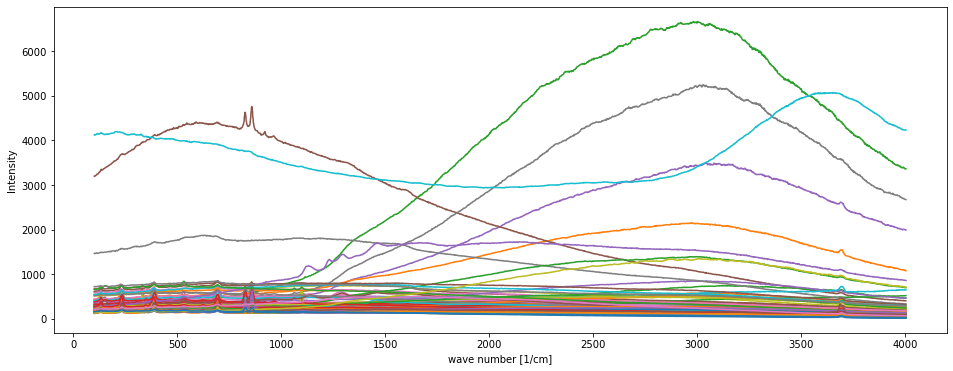

In [12]:
raman_plot()
for temp in names[1:]:
    plt.plot(data.wn,data[temp])

**Spettri sperimentali non normalizzati senza rumore di background**

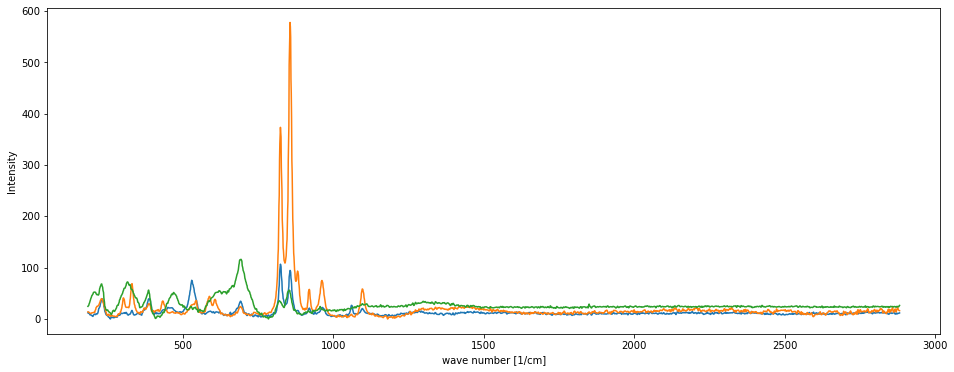

In [13]:
raman_plot()
plt.plot(data_bkg.wn,data_bkg.r1c1)
plt.plot(data_bkg.wn,data_bkg.r1c2)
plt.plot(data_bkg.wn,data_bkg.r1c3);

**tutti gli spettri sperimentali non normalizzati senza rumore**

Tutti gli spettri puri normalizzati


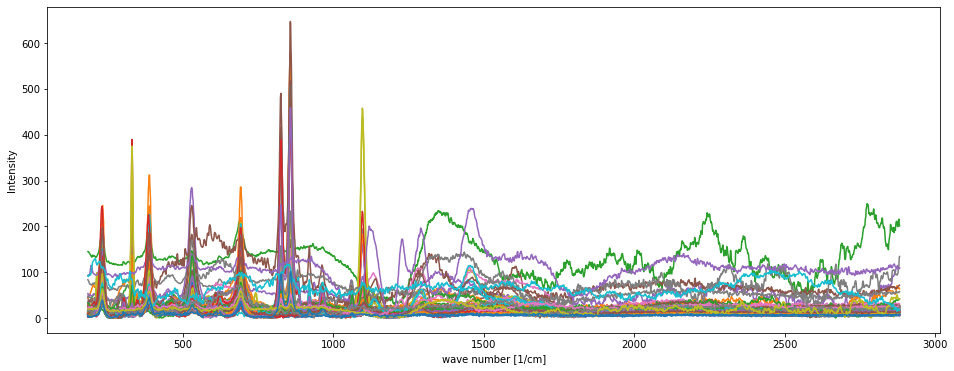

In [14]:
raman_plot()
print(plt.title)
for temp in names[1:]:
    plt.plot(data_bkg.wn,data_bkg[temp])

**Differenza tra uno spettro con rumore di background e uno senza**

Differenza tra uno spettro con rumore di background e uno senza


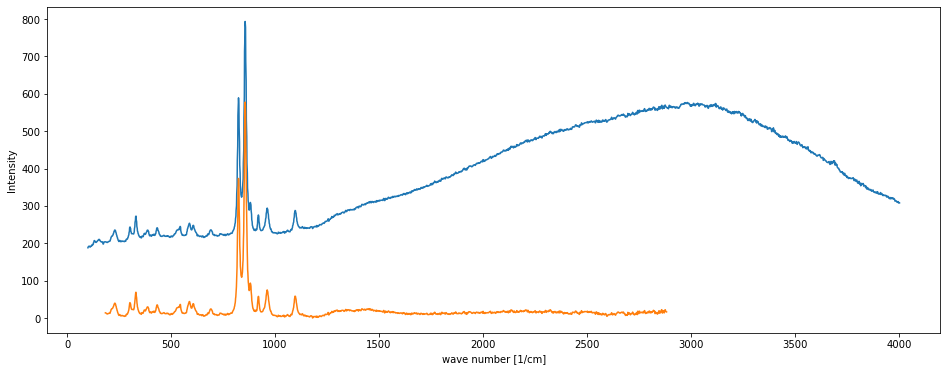

In [15]:
raman_plot()
plt.plot(data.wn,data.r1c2)
plt.plot(data_bkg.wn,data_bkg.r1c2)

### Normalizzazione degli spettri sperimentali

In [16]:
for i in names[1::]:
    data_bkg[i]=data_bkg[i]/np.trapz((data_bkg[i]), x=data_bkg.wn)

**Tutti gli spettri sperimentali normalizzati senza rumore**

tutti gli spettri sperimentali normalizzati senza rumore


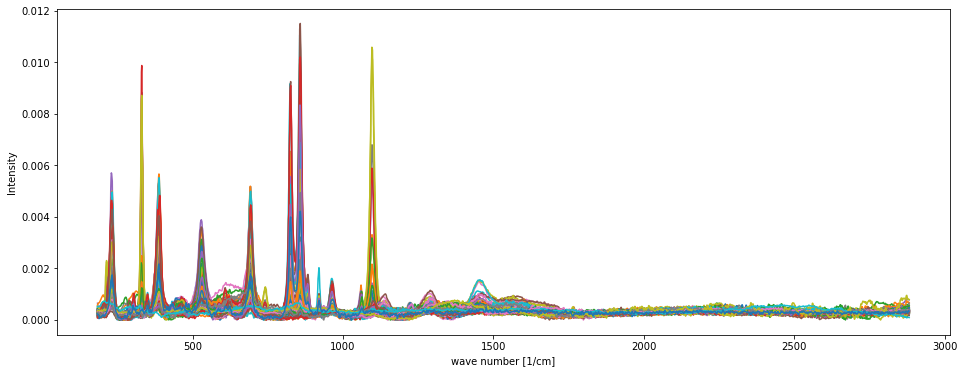

In [17]:
raman_plot()
print(plt.title)
for temp in names[1:]:
    plt.plot(data_bkg.wn,data_bkg[temp])

### Tentativo di rimuovere il rumore
Abbiamo visto che non funziona tanto bene, **abbassa molto il picco e si perde informazione**, ma con binning N = 2 potrebbe agevolare computazionalmente il processo.

In [18]:
sample='r7c7' #scelgo su cosa guardare sta roba
N=2 #numero di raggruppamenti
x=[]
y=[]
for i in range(int(len(data_bkg[sample])/N)):
    y.append(data_bkg[sample][N*i:N*i+N].mean())   
for i in range(int(len(data_bkg.wn)/N)):
    x.append(data_bkg.wn[N*i:N*i+N].mean())   

Tentativo di rimuovere il rumore


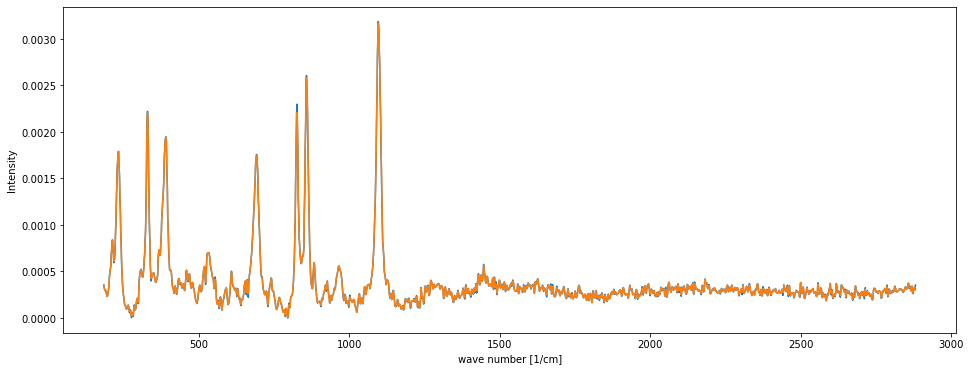

In [19]:
raman_plot()
plt.plot(data_bkg.wn,data_bkg[sample])
plt.plot(x,y)
print("Tentativo di rimuovere il rumore")

### Rimozione offset
Lo facciamo facendo un fit alla coda dello spettro, dopo la frequenza di soglia (che dobbiamo ancora segliere bene)

Osservando gli spettri puri si nota che l'intensita' questi per frequenze alte va a zero.
L'intensita' degli spettri sperimentali per frequenze elevate non va a zero, ipotizziamo questo fatto al processo di misura e non alla fisica del problema. Scegliamo quindi di rimuovere l'offset per ogni spettro. 

In [20]:
wn_soglia=1250

**Esempio**

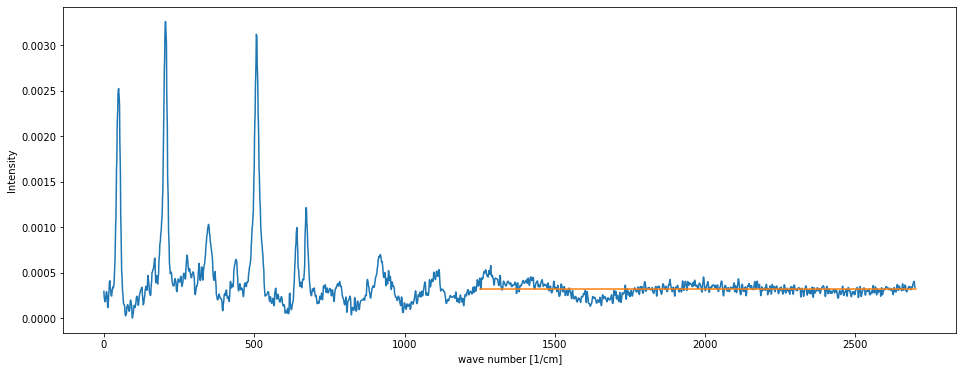

In [21]:
raman_plot()
sample='r4c7' #il sample su cui faccio gli esempi
data_bkg[sample].plot()
offset=data_bkg[sample][wn_soglia::].mean()
sigma=data_bkg[sample][wn_soglia::].std() #calcolo la std che mi serve dopo

plt.plot([wn_soglia,2700],[offset,offset]);

Implementiamo il procedimento su tutti i sample

In [22]:
for temp in names[1::]:
    offset=data_bkg[temp][wn_soglia::].mean()
    data_bkg[temp]=data_bkg[temp]-offset

### Mettiamo una sogli al rumore in base alla varianza calcolata sulla coda dello spettro

Per tentare di ridurre il rumore sugli spettri sperimentali procediamo in questo modo.
Ipotizziamo che il rumore non dipenda dalla frequenza e facendo un fit alla parte finale della coda (quella che per confronto con gli spettri puri dovrebbe essere a zero) fissiamo una soglia in base alla varianza delle intensita' della coda. Teniamo solo i dati che sono al di fuori di questa soglia, quelli al di sotto li consideriamo come rumore e vi attribuiamo un intensita' nulla.

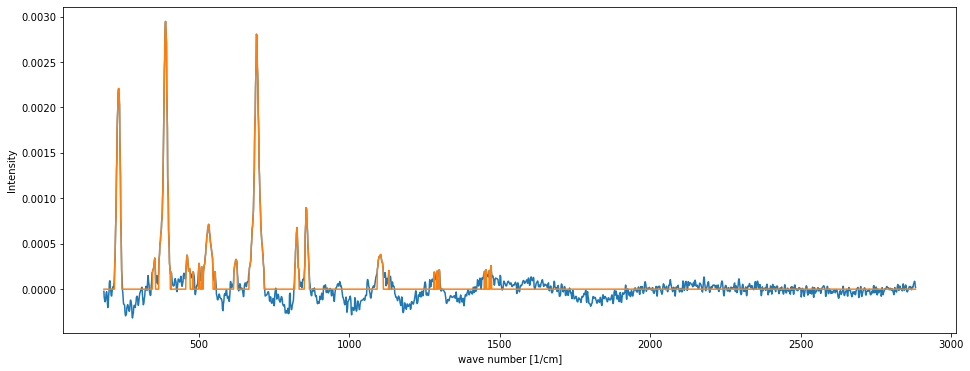

In [23]:
bound=3*sigma #fisso il bound del rumore a 3 volte il sigma della coda
y=data_bkg[sample].copy()
for i in enumerate(y):
    if i[1]<bound:
        y[i[0]]=0
x=data_bkg.wn

raman_plot()
plt.plot(data_bkg.wn,data_bkg[sample])    
plt.plot(x,y);

Lo faccio poi per tutti gli spettri

In [24]:
for temp in names[1::]:
    for i in enumerate(data_bkg[temp]):
        if i[1]<bound:
            data_bkg[temp][i[0]]=0

###  Eliminazione della coda e rinormalizzazione finale

In [25]:
# qui elimino la coda
temp = np.min(np.where(data_bkg.wn > wn_soglia)) # questo e' per trovare l'indice della frequenza di soglia
data_bkg = data_bkg[1:temp]

In [26]:
# qui rinormalizzo
for i in names[1::]:
    data_bkg[i]=data_bkg[i]/np.trapz((data_bkg[i]), x=data_bkg.wn)

Adesso gli spettri hanno questa forma

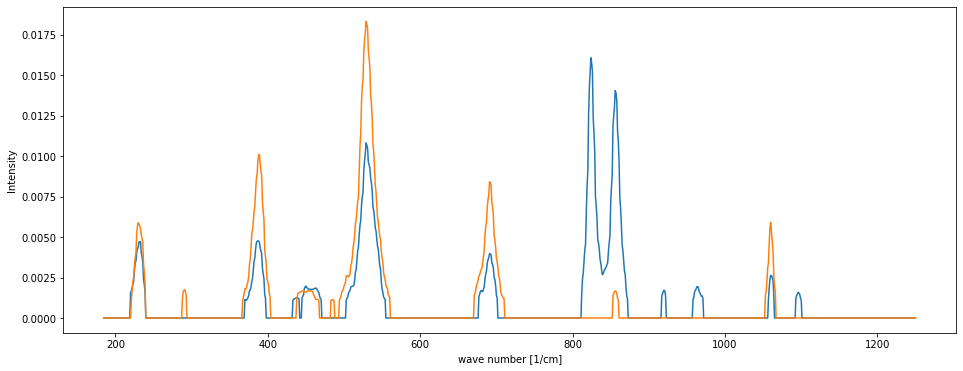

In [27]:
raman_plot()
plt.plot(data_bkg.wn,data_bkg.r1c1)
plt.plot(data_bkg.wn,data_bkg.r2c1);

## Salvataggio dei dati

In [32]:
data_bkg.to_csv("../data/processed/EDA_processed_data.csv")